# <span style='background-color: #fff5b1'>오늘의 한 걸음  🚶🏽‍♂️: 한영 번역기 만들기</span>

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리  
        -1. 오타 
    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


오늘은 한국어- 영어 병렬데이터로  

seq2seq - Attention 구조를 이용한  
딥러닝 번역기를 만들어보도록 한다!!!!!

깃허브의 Jungyeul Park 님께서, 우리같은 NLP린이 들을 위해  
한국어-영어 병렬 데이터를 제공해주신다.  

[ko-En parallel data](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

이 데이터를 가지고 
seq2seq 에 bahdanaw Attention 이 도입된 모델을 학습시켜  
한국어를 영어로 번역해주는 기능을 만들 것이다.


전체적인 순서를 설명하면 다음과 같다.

1. 한-영 데이터 불러오기
2. 데이터 전처리  
( 오탈자 및 오타 제거, 토큰화, 디코딩에 들어갈 영어데이터 sos,end 토큰 추가, 패딩처리, 텐서화 )

3. seq2seq- Attention 모델 설계
4. 모델 학습

5. 모델 평가

오늘의 Rubric 은 다음과 같다.

|평가문항|상세기준|
|---|---|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.|


## 1-2. 사용하는 라이브러리

In [1]:
import time
import re
import os
import io
import numpy as np
import pandas

import tensorflow
import matplotlib

print(pandas.__version__)
print(tensorflow.__version__)
print(matplotlib.__version__)

1.3.3
2.6.0
3.4.3


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
#한국어 지원 폰트로 변경

%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


# 2. GAME
## 2-1. 데이터 읽어오기

상위에 기재한 링크에서 파일을 다운로드 받아 불러왔다.

In [22]:
ko_path = os.getenv('HOME')+'/aiffel/goingDeeper/s2s_translation/korean-english-park.train.ko' 

with open(ko_path, "r") as f:
    ko_raw = f.read().splitlines()
    
ko_raw[:8]

['개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
 '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
 '그러나 이것은 또한 책상도 필요로 하지 않는다.',
 '79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
 '정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
 '이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.',
 '국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.',
 '이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.']

In [23]:
en_path = os.getenv('HOME')+'/aiffel/goingDeeper/s2s_translation/korean-english-park.train.en' 

with open(en_path, "r") as f:
    en_raw = f.read().splitlines()
    
en_raw[:8]

['Much of personal computing is about "can you top this?"',
 'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.',
 "Like all optical mice, But it also doesn't need a desk.",
 'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.',
 "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.",
 "After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.",
 'Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or who need help staying alert for longer

## 2-2.데이터 전처리

### 1. 결측치, 오타 제거, 길이 조절

In [24]:

def en_preprocess_sentence(sentence):
    sentence = sentence.strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    sentence = '<start> ' + sentence + ' <end>' #디코더에 넣을 것이므로 sos, eos 토큰 처리


    return sentence

def ko_preprocess_sentence(sentence):
    
    sentence = sentence.strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"^[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", " ", sentence)
    sentence = re.sub(r"([a-zA-Z]+)", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()

    
    return sentence

    

In [25]:
#en_raw = list(set(en_raw))
#ko_raw = list(set(ko_raw)) # 중복제거

en = list(map(en_preprocess_sentence,en_raw))
ko = list(map(ko_preprocess_sentence,ko_raw)) # 결측치, 오타값 제거

for b,a in zip(en[:3],ko[:3]):
    print(f'번역 전 : {a}\n번역 후: {b}\n')

번역 전 : 개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
번역 후: <start> Much of personal computing is about can you top this ? <end>

번역 전 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 .
번역 후: <start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse . <end>

번역 전 : 그러나 이것은 또한 책상도 필요로 하지 않는다 .
번역 후: <start> Like all optical mice , But it also doesn t need a desk . <end>



In [37]:
from konlpy.tag import Mecab

mecab = Mecab()

mecab.morphs('배고파서 밥을 먹었다')



['배고파서', '밥', '을', '먹', '었', '다']

In [16]:
len(en), len(ko)

(94123, 94123)

In [27]:
len(ko[0].split())

10

/tmp/ipykernel_31/2380430096.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


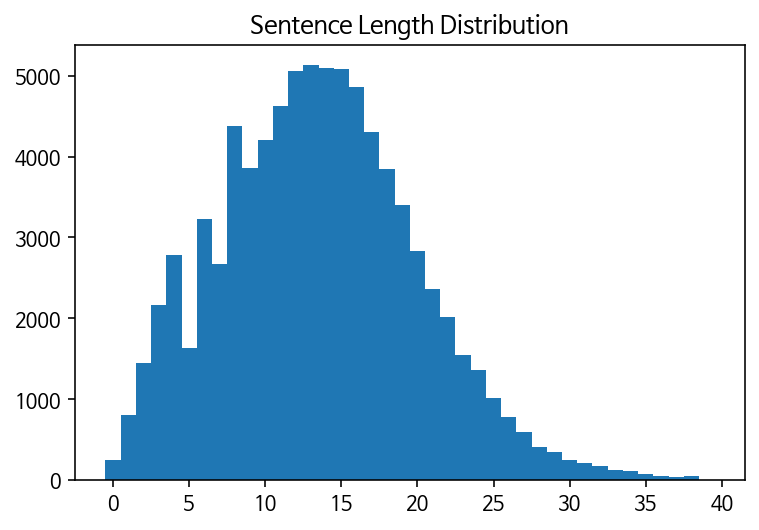

In [31]:
max_len = 40 # 2번

# 한글 영어 모두 길이 조건에 맞는 문장 선택
filtered_en = [en for en, ko in zip(en, ko) if (len(en.split()) < max_len) & (len(ko.split()) < max_len) ]

filtered_ko = [ko for en, ko in zip(en, ko) if (len(en.split()) < max_len) & (len(ko.split()) < max_len) ]

# 분포도로 시각화.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_ko :
    sentence_length[len(sen.split())-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 2. 토큰화

In [ ]:

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='10000')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## 2-3.모델 학습

## 2-4.데이터 평가

# 3. POTG
## 3-1. 소감

## 3-2. 어려웠던 점과 극복방안

1. 전처리 작업에 있어   
영어과 한국어 데이터에 빼야 할 요소가 달라  
한번에 처리해주기가 곤란했다.  
시간만 더 있었다면 Dataframe 으로 받아 디테일하게 처리했을텐데.

2. Mecab 형태소 분리를 진행하는 도중   
예상치 못한 에러를 만났다

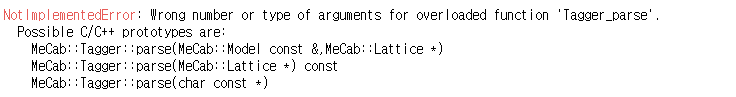

확인해보니 `morphs` 메서드는 리스트를 받지 않았다.

시간만 더 있었으면 끝까지 할 수 있었을텐데,,, 아쉽다 ㅜㅜ

## 3-3. 추후